In [ ]:
using DataFrames, MLJ

In [ ]:
X, y = @load_boston;
X = DataFrame(X)
y = Vector(y);

In [ ]:
rr_model = @load RidgeRegressor pkg=MLJLinearModels
rr_pipe = @pipeline Standardizer rr_model

In [ ]:
fieldnames(rr_model)

In [ ]:
rf_model = @load RandomForestRegressor pkg=DecisionTree add=true
rf_pipe = @pipeline Standardizer rf_model

In [ ]:
r = [
    range(rf_pipe, :(random_forest_regressor.max_depth), lower=1, upper=5),
    range(rf_pipe, :(random_forest_regressor.n_trees), lower=10, upper=50)
    ]

tuned2 = TunedModel(model=rf_pipe,
                    range=r,
                    measure=rms);
m = machine(tuned2, X, y) |> fit!
fitted_params(m).best_model

In [ ]:
tuned_model = TunedModel(
    models=[rr_pipe, rf_pipe],
    measure=rms,
    train_best=true
)

In [ ]:
m = machine(tuned_model, X, y) |> fit!

In [ ]:
fitted_params(m)

In [ ]:
r = report(m)
@show r.best_history_entry.measurement;

In [ ]:
r.best_model

In [ ]:
r.best_report

# Testing `@pipelines`

In [36]:
using DataFrames, MLJ, VegaLite
X, y = @load_boston;
X = DataFrame(X)
y = Vector(y);

In [9]:
rr_model = @load RidgeRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\loading.jl:168


MLJLinearModels.RidgeRegressor

In [15]:
# pipeline with target transformation (log) and inverse transformation (exp)
rr_pipe = @pipeline(Standardizer,
                    rr_model,
                    target=UnivariateBoxCoxTransformer)
                    # ,
                    # inverse=exp)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372


Pipeline316(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    ridge_regressor = RidgeRegressor(
            lambda = 1.0,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing),
    target = UnivariateBoxCoxTransformer(
            n = 171,
            shift = false))

In [16]:
m = machine(rr_pipe, X, y)
fit!(m)

┌ Info: Training Machine{Pipeline316,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{UnivariateBoxCoxTransformer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{RidgeRegressor,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{Pipeline316,…} trained 1 time; caches data
  args: 
    1:	Source @664 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @399 ⏎ `AbstractVector{Continuous}`


In [19]:
fitted_params(m)

(target = (λ = 0.2,
           c = 0.0,),
 ridge_regressor = (coefs = [:Crim => -0.1434897064585308, :Zn => 0.05804038814828052, :Indus => 0.033364636769331255, :NOx => -0.16146747400428088, :Rm => 0.14159177019283434, :Age => 0.010176882019717056, :Dis => -0.20396275017863416, :Rad => 0.23266123502689876, :Tax => -0.19954638600901334, :PTRatio => -0.1613666829816568, :Black => 0.07317409602909465, :LStat => -0.3678032681197902],
                    intercept = 4.195789751931853,),
 standardizer = Dict(:Zn => (11.363636363636363, 23.322452994515135), :Rad => (9.549407114624506, 8.707259384239368), :Tax => (408.2371541501976, 168.537116054959), :LStat => (12.653063241106722, 7.141061511348569), :Rm => (6.284634387351778, 0.7026171434153233), :Age => (68.57490118577076, 28.148861406903617), :NOx => (0.5546950592885372, 0.11587767566755595), :Indus => (11.136778656126486, 6.8603529408975845), :Dis => (3.795042687747036, 2.105710126627611), :PTRatio => (18.45553359683795, 2.164945523714440

In [24]:
r = report(m)

(target = (),
 ridge_regressor = (),
 standardizer = (features_fit = [:Zn, :Rad, :Tax, :LStat, :Rm, :Age, :NOx, :Indus, :Dis, :PTRatio, :Crim, :Black],),
 machines = Machine[Machine{Standardizer,…}, Machine{RidgeRegressor,…}, Machine{UnivariateBoxCoxTransformer,…}],
 report_given_machine = OrderedCollections.LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{Standardizer,…} => (features_fit = [:Zn, :Rad, :Tax, :LStat, :Rm, :Age, :NOx, :Indus, :Dis, :PTRatio, :Crim, :Black],), Machine{RidgeRegressor,…} => NamedTuple(), Machine{UnivariateBoxCoxTransformer,…} => NamedTuple()),)

In [40]:
X

,Crim,Zn,Indus,NOx,Rm,Age,Dis,Rad,Tax
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0.538,6.575,65.2,4.09,1.0,296.0
2,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0
3,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0
4,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0
5,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0
6,0.02985,0.0,2.18,0.458,6.43,58.7,6.0622,3.0,222.0
7,0.08829,12.5,7.87,0.524,6.012,66.6,5.5605,5.0,311.0
8,0.14455,12.5,7.87,0.524,6.172,96.1,5.9505,5.0,311.0
9,0.21124,12.5,7.87,0.524,5.631,100.0,6.0821,5.0,311.0


In [46]:
boxcox = UnivariateBoxCoxTransformer();
mach = fit!(machine(boxcox, y))
a, b = MLJ.transform(mach, y), y

┌ Info: Training Machine{UnivariateBoxCoxTransformer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


([4.440875112949019, 4.244017406098535, 5.16332700658519, 5.086007753878703, 5.24971331782347, 4.784674518535251, 4.352702084512374, 4.673059574360529, 3.7592474052544134, 4.000411485005378  …  4.075347210987173, 3.94252622170678, 4.209523841516984, 3.862936017026218, 3.790870059843446, 4.311499150948377, 4.156794093138001, 4.432994571818286, 4.278003681290421, 3.2050153262613432], [24.0, 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9  …  19.7, 18.3, 21.2, 17.5, 16.8, 22.4, 20.6, 23.9, 22.0, 11.9])

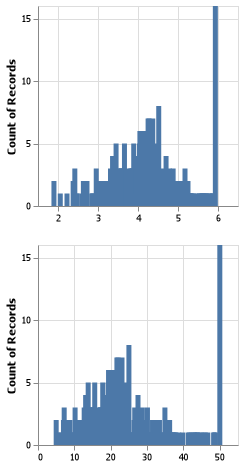

In [81]:
DataFrame(a=a,b=b) |> 

[
    @vlplot(
        :bar,
        x=a,
        y="count()"
    ) ;
    @vlplot(
        :bar,
        x=b,
        y="count()"
    )
]
